In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import wave as we
import math
import ctypes as ct  #C compatible data types
from IPython.display import Audio



def read_wav(wavfile):
    f = wavfile
    params = f.getparams()

    nchannels, sampwidth, framerate, nframes = params[:4]
    strData = f.readframes(nframes)
    waveData = np.frombuffer(strData, dtype=np.int16)

    time = np.arange(0, nframes)*(1.0 / framerate)
    plt.plot(time, waveData)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Wavedata")
    plt.show()
    return (waveData, time)


class FloatBits(ct.Structure):
    _fields_ = [
        ('M', ct.c_uint, 23),       #unsigned int
        ('E', ct.c_uint, 8),
        ('S', ct.c_uint, 1)
    ]
  
class Float(ct.Union):
    _anonymous_ = ('bits',)
    _fields_ = [
        ('value', ct.c_float),      
        ('bits', FloatBits)
    ]
 
def nextpow2(x):  #return smallest power of 2 greater than or equal to abs(x)
    if x < 0:
        x = -x
    if x == 0:
        return 0
    d = Float()
    d.value = x
    if d.M == 0:
        return d.E - 127
    return d.E - 127 + 1

# Open WAV file
f = we.open("merged_noisy/common_voice_en_37285574_noisy.wav")
 
# Read format information
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate
# Reads the waveform data
str_data = f.readframes(nframes)
f.close()
 # Waveform data into an array
x = np.fromstring(str_data, dtype=np.short)
# Calculation parameters
len_ = 20 * fs // 1000  #Typically frames are taken to be about 20ms long
PERC = 50  #percent overlap
len1 = len_ * PERC // 100
len2 = len_ - len1
# Set the default parameters
Thres = 1
Expnt = 2.0
beta = 1
G = 1

# Initialize Hamming window to window each frame
win = np.hamming(len_)
# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)
 
 
# Noise magnitude calculations - assuming that the first 5 frames is noise/silence
nFFT = 2 * 2 ** (nextpow2(len_))
noise_mean = np.zeros(nFFT)
 
j = 0
for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * x[j:j + len_], nFFT))
    j = j + len_
noise_mu = noise_mean / 5
 

# --- allocate memory and initialize various variables
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)
 
 
# =========================    Start Processing   ===============================
for n in range(0, Nframes):
    # Windowing
    insign = win * x[k-1:k + len_ - 1]
    # compute fourier transform of a frame
    spec = np.fft.fft(insign, nFFT)
    # compute the magnitude
    sig = abs(spec)
    # save the noisy phase information
    theta = np.angle(spec)
    SNRseg = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)
 
    
    #SNR = signal to noise ratio
    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR * 3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a
 
 
    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR * 2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a
 
 
    if Expnt == 1.0: # magnitude spectrum
        alpha = berouti1(SNRseg)
    else: # the power spectrum
        alpha = berouti(SNRseg)
    
    #spectral subtraction
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt;
         # Signal is smaller than the power when the pure noise signal
    diffw = sub_speech - beta * noise_mu ** Expnt
    # beta negative components
 
 
    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list
 
 
    z = find_index(diffw)
    if len(z) > 0:
        # With lower estimated noise signal represents the limit
        sub_speech[z] = beta * noise_mu[z] ** Expnt
        # --- implement a simple VAD (voice activity detection) detector --------------
        if SNRseg < Thres:  # Update noise spectrum
            noise_temp = G * noise_mu ** Expnt + (1 - G) * sig ** Expnt # smoothing processing noise power spectrum
            noise_mu = noise_temp ** (1 / Expnt) # new noise amplitude spectrum
            # Flipud = turned upside down of a matrix of functions, based on the "horizontal line" axis of symmetry of the matrix
            #Vertically symmetrical switching elements 
        sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
        x_phase = (sub_speech ** (1 / Expnt)) * (np.array([math.cos(x) for x in theta]) + img * (np.array([math.sin(x) for x in theta])))
        
        #Reconstructing the original signal
        # take the IFFT
        xi = np.fft.ifft(x_phase).real
        #Overlap and add
        xfinal[k-1:k + len2 - 1] = x_old + xi[0:len1]
        x_old = xi[0 + len1:len_]
        k = k + len2
 

# save document 
wf = we.open('spectral_sub_12.wav', 'wb')
# Setting parameters 
wf.setparams(params)
# .toString wave file () to convert the data array
wave_data = (winGain * xfinal).astype(np.short)
wf.writeframes(wave_data.tostring())
wf.close()

f = we.open("spectral_sub_12.wav", 'rb')
print("\nSpectral Subtraction wave data:")
read_wav(f)

display(Audio(spectral_sub_12, rate=22050))

C:\Users\Shubhrika\anaconda3\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Shubhrika\AppData\Local\Temp\ipykernel_33212\1456105340.py:65: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(str_data, dtype=np.short)


ValueError: could not broadcast input array from shape (220,) into shape (221,)

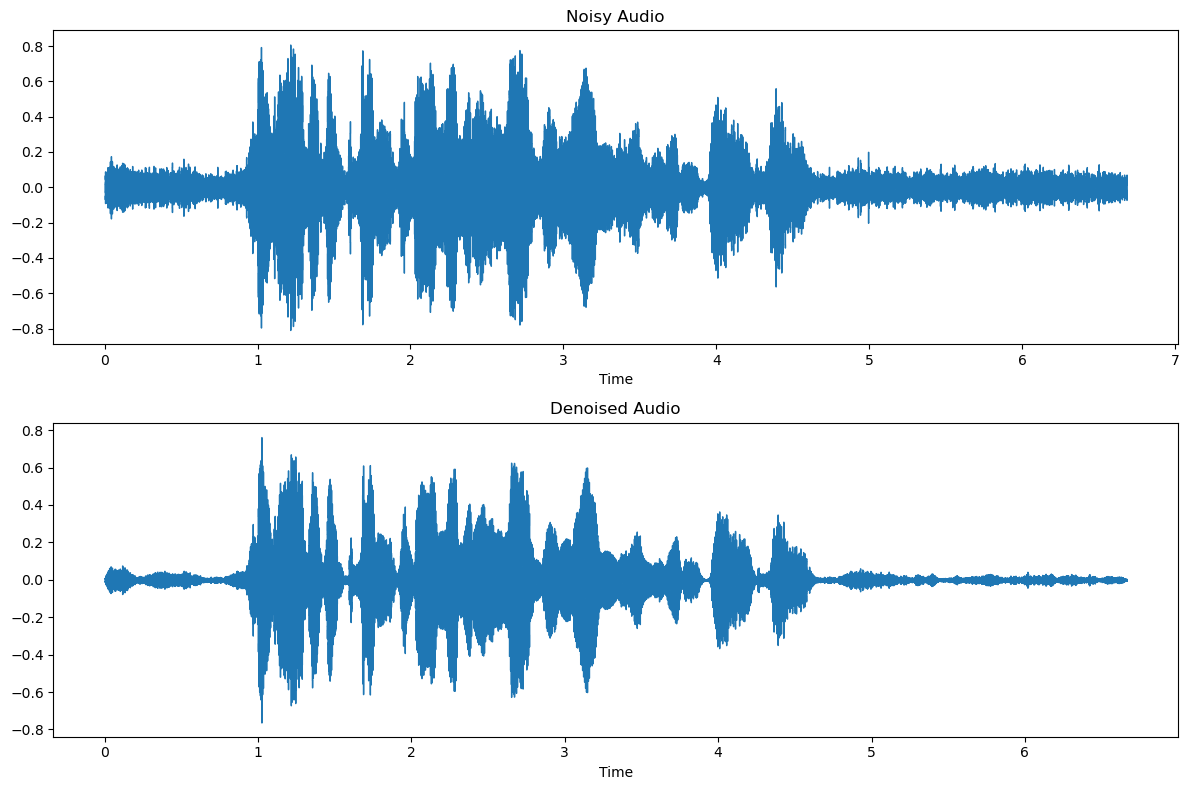

In [9]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio


def spectral_subtraction(noisy_audio, sr, noise_reduction_factor=1.0):
    # Perform Short-Time Fourier Transform (STFT)
    stft_noisy = librosa.stft(noisy_audio)

    # Estimate the noise power spectrum
    noise_estimation = np.mean(np.abs(stft_noisy), axis=1)
    
    # Perform spectral subtraction
    subtracted_spectrum = np.abs(stft_noisy) - noise_reduction_factor * noise_estimation[:, None]
    subtracted_spectrum[subtracted_spectrum < 0] = 0  # Remove negative values

    # Combine the subtracted magnitude with the original phase
    denoised_stft = subtracted_spectrum * np.exp(1j * np.angle(stft_noisy))

    # Inverse STFT to get the denoised audio signal
    denoised_audio = librosa.istft(denoised_stft)

    return denoised_audio

# Load a noisy audio file (replace 'path_to_your_noisy_audio.wav' with your audio file's path)
file_path = 'merged_noisy/common_voice_en_37285574_noisy.wav'
noisy_audio, sr = librosa.load(file_path, sr=None)

# Apply spectral subtraction
denoised_audio = spectral_subtraction(noisy_audio, sr)

# Plot the original and denoised audio for comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title('Noisy Audio')
plt.subplot(2, 1, 2)
librosa.display.waveshow(denoised_audio, sr=sr)
plt.title('Denoised Audio')
plt.tight_layout()
plt.show()


display(Audio(noisy_audio, rate=22050))


display(Audio(denoised_audio, rate= 22050))

import soundfile as sf

# Save the denoised audio using soundfile
output_file_path = 'denoised_audio.wav'
sf.write(output_file_path, denoised_audio, sr)



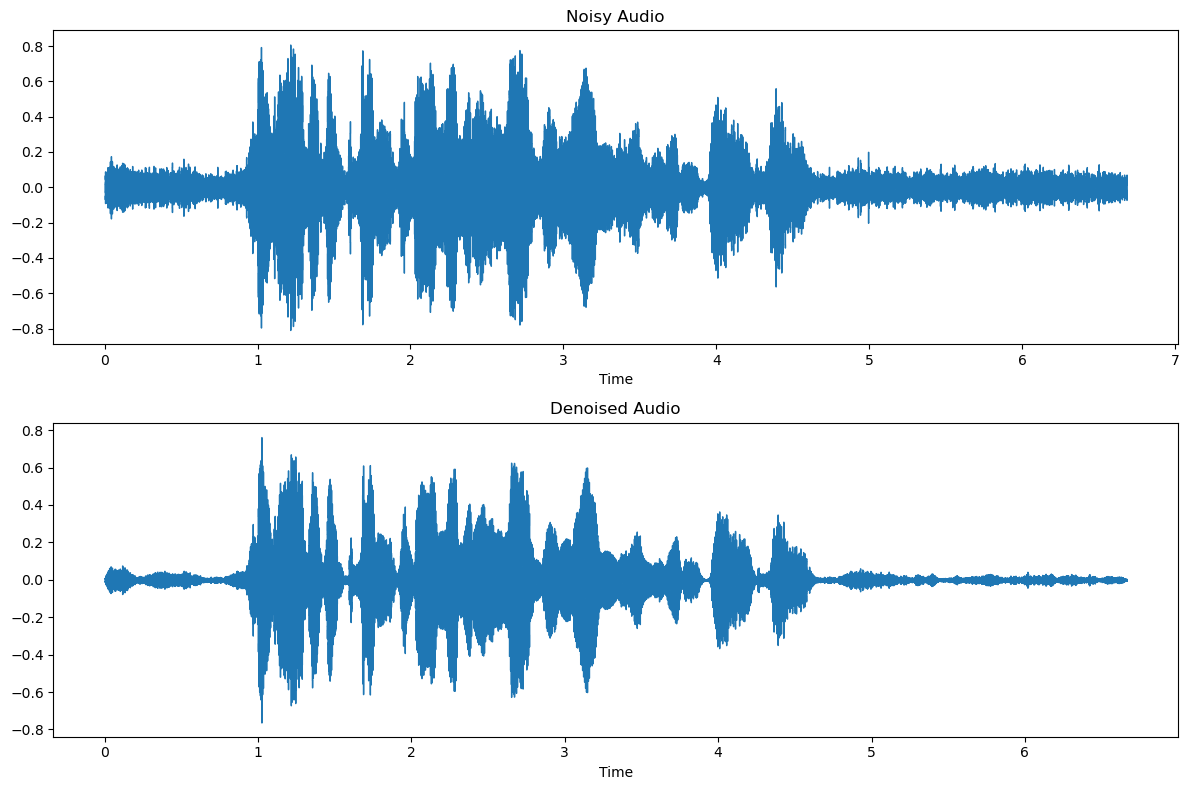

In [10]:
import numpy as np
import librosa
import librosa.display
import scipy.signal
import matplotlib.pyplot as plt

def wiener_filter_denoising(audio, sr, frame_length=512, frame_step=256):
    # Compute the Short-Time Fourier Transform (STFT)
    stft_audio = librosa.stft(audio, n_fft=frame_length, hop_length=frame_step)

    # Compute magnitude and phase
    magnitude, phase = librosa.magphase(stft_audio)

    # Apply Wiener filter
    wiener_filtered_magnitude = scipy.signal.wiener(magnitude)

    # Reconstruct signal
    reconstructed_audio = librosa.istft(wiener_filtered_magnitude * phase, hop_length=frame_step)

    return reconstructed_audio

# Load a noisy audio file (replace with your file path)
file_path = 'merged_noisy/common_voice_en_37285574_noisy.wav'
noisy_audio1, sr = librosa.load(file_path, sr=None)

# Apply Wiener filtering
denoised_audio1 = wiener_filter_denoising(noisy_audio, sr)

# Plotting the original and denoised audio for comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title('Noisy Audio')
plt.subplot(2, 1, 2)
librosa.display.waveshow(denoised_audio, sr=sr)
plt.title('Denoised Audio')
plt.tight_layout()
plt.show()


display(Audio(noisy_audio1, rate=22050))


display(Audio(denoised_audio1, rate= 22050))


# Save the denoised audio using soundfile
output_file_path = 'denoised_audio1.wav'
sf.write(output_file_path, denoised_audio1, sr)